# Intro Task, Object Localization

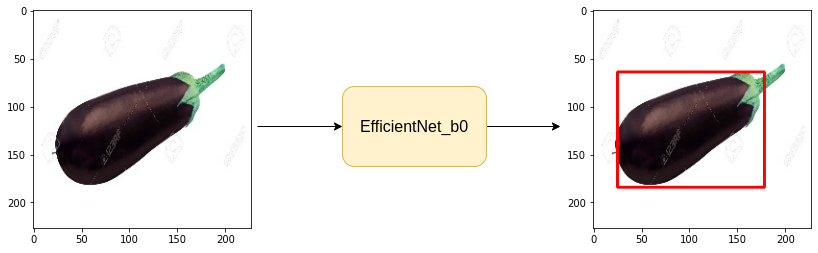

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-6ruz6kle
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-6ruz6kle
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 8.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python-4.8.0.76:
      Successfully uninstalled opencv-contrib-python-4.8.0.76


In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 12.79 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
csv_file = '/content/object-localization-dataset/train.csv'
data_dir = '/content/object-localization-dataset/'

device='cuda'
batch_size=16
img_size=140
lr=0.001
epochs=40
model= 'efficientnet_b0'

num_cor =4

In [ ]:
df=pd.read_csv(csv_file)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

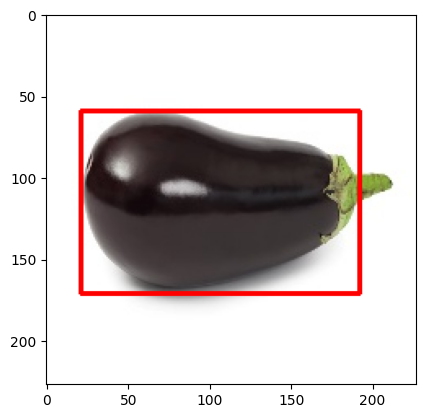

In [ ]:
row = df.iloc[184]
img = cv2.imread(data_dir + row.img_path)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1= (row.xmin, row.ymin)
pt2= (row.xmax, row.ymax)
bnd_box_img=cv2.rectangle(img1, pt1, pt2, (255,0, 0), 2)
plt.imshow(bnd_box_img)


In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [ ]:
import albumentations as A
!pip show albumentations


Name: albumentations
Version: 1.3.1
Summary: Fast image augmentation library and easy to use wrapper around other libraries
Home-page: https://github.com/albumentations-team/albumentations
Author: Buslaev Alexander, Alexander Parinov, Vladimir Iglovikov, Eugene Khvedchenya, Druzhinin Mikhail
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, opencv-python-headless, PyYAML, qudida, scikit-image, scipy
Required-by: 


In [ ]:
train_augs = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(img_size, img_size)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    row=self.df.iloc[idx]
    xmin=row.xmin
    ymin=row.ymin
    xmax=row.xmax
    ymax=row.ymax
    bbox=[[xmin, ymin, xmax, ymax]]
    img_path=data_dir+row.img_path
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data=self.augmentations(image=img, bboxes=bbox, class_labels = [None])
      img= data['image']
      bbox=data['bboxes'][0]

    img=torch.from_numpy(img). permute(2, 0, 1)/255.0
    bbox=torch.Tensor(bbox)
    return img, bbox

In [ ]:
trainset=ObjLocDataset(train_df, train_augs)
validset=ObjLocDataset(valid_df, valid_augs)

In [ ]:
print(f"total examples in the train set: {len(trainset)}")
print(f"total examples in the valid set: {len(validset)}")

total examples in the train set: 148
total examples in the valid set: 38


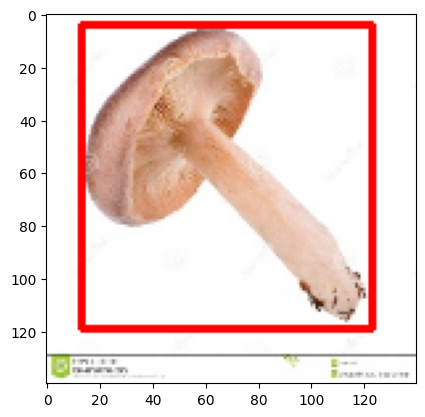

In [ ]:
img, bbox = trainset[120]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader=torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True )
validloader=torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False )

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images, bboxes in trainloader:
  break

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn
import timm

In [ ]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()
    self.backbone=timm.create_model(model, pretrained=True, num_classes=4)
  def forward(self,images, gt_bboxes=None):
    bboxes=self.backbone(images)
    if gt_bboxes !=None:
      loss=nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss
    else:
      return bboxes

In [ ]:
model = ObjLocModel()
model.to(device);

In [ ]:
random_img=torch.rand(1,3,140, 140).to(device)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train(model, dataloader, optimizer):
  total_loss=0.0
  model.train()

  for data in tqdm(dataloader):
    images, gt_bboxes=data
    images, gt_bboxes= images.to(device), gt_bboxes.to(device)

    bboxes,loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(dataloader)

In [ ]:
def eval(model, dataloader):
  total_loss=0.0
  model.eval()
  with torch.no_grad():

    for data in tqdm(dataloader):
      images, gt_bboxes=data
      images, gt_bboxes= images.to(device), gt_bboxes.to(device)

      bboxes,loss = model(images, gt_bboxes)
      total_loss+=loss.item()

    return total_loss/len(dataloader)

#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
best_valid_loss = np.Inf
for i in range(epochs):
  train_loss = train(model, trainloader, optimizer)
  valid_loss = eval(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('weights are saved')
    best_valid_loss = valid_loss

  print(f'epoch: {i+1} train loss: {train_loss} valid loss: {valid_loss}')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
epoch: 1 train loss: 5194.896435546875 valid loss: 5942.500162760417


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
epoch: 2 train loss: 1875.6084594726562 valid loss: 3465.2421875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
epoch: 3 train loss: 1070.9437438964844 valid loss: 474.8203430175781


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
epoch: 4 train loss: 729.5880645751953 valid loss: 318.1607666015625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
epoch: 5 train loss: 462.0207000732422 valid loss: 215.1042734781901


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
epoch: 6 train loss: 320.5358139038086 valid loss: 189.34237162272134


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
epoch: 7 train loss: 291.592512512207 valid loss: 174.52225240071616


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
epoch: 8 train loss: 170.6765594482422 valid loss: 135.38934834798178


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
epoch: 9 train loss: 164.82283706665038 valid loss: 120.7317403157552


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 10 train loss: 135.84424209594727 valid loss: 123.58102671305339


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 11 train loss: 135.59964904785156 valid loss: 130.38990783691406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
epoch: 12 train loss: 98.15573272705078 valid loss: 102.9808858235677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 13 train loss: 84.25577545166016 valid loss: 113.58682759602864


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 14 train loss: 93.34854927062989 valid loss: 170.0460459391276


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 15 train loss: 97.68488464355468 valid loss: 125.96822357177734


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 16 train loss: 78.28630027770996 valid loss: 117.11593373616536


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 17 train loss: 76.20234937667847 valid loss: 112.41626993815105


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 18 train loss: 67.85000076293946 valid loss: 130.44829305013022


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 19 train loss: 74.51371383666992 valid loss: 130.51991271972656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
epoch: 20 train loss: 69.99493942260742 valid loss: 96.34216562906902


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 21 train loss: 73.21836166381836 valid loss: 104.47735850016277


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
epoch: 22 train loss: 72.66073379516601 valid loss: 94.48967997233073


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
epoch: 23 train loss: 83.24817504882813 valid loss: 66.87085723876953


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 24 train loss: 66.95725784301757 valid loss: 161.30406697591147


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 25 train loss: 50.799735641479494 valid loss: 105.15408070882161


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 26 train loss: 60.11761054992676 valid loss: 71.27921549479167


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 27 train loss: 53.53340721130371 valid loss: 83.8067855834961


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 28 train loss: 42.75261878967285 valid loss: 86.93311055501302


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 29 train loss: 47.641324043273926 valid loss: 81.9425417582194


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 30 train loss: 39.03564891815186 valid loss: 81.8325703938802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
epoch: 31 train loss: 47.555091857910156 valid loss: 55.132792154947914


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 32 train loss: 43.620486450195315 valid loss: 74.19021097819011


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 33 train loss: 42.937638664245604 valid loss: 70.18407567342122


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 34 train loss: 43.893666458129886 valid loss: 76.0591417948405


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 35 train loss: 38.83819007873535 valid loss: 83.99519856770833


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 36 train loss: 43.591993141174314 valid loss: 67.64671834309895


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 37 train loss: 43.141828536987305 valid loss: 76.28956095377605


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 38 train loss: 42.55061588287354 valid loss: 63.371107737223305


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 39 train loss: 32.237509155273436 valid loss: 57.192962646484375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 40 train loss: 46.602324676513675 valid loss: 78.74862798055013


#Inference

In [ ]:
import utils

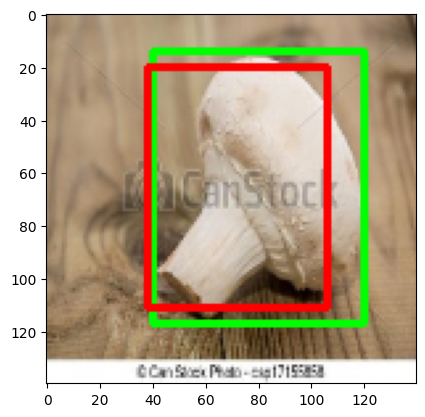

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
  image, gt_bbox = validset[23]
  image = image.unsqueeze(0).to(device)
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)
